# Selection of the hyperparameter

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load gene expression and drug response data
gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gene_expression)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gene_expression, drug_response, test_size=0.2, random_state=42)

# Create a Lasso regression model
lasso = Lasso(max_iter=10000)

# Define the range of alpha values to search
alphas = [0.01, 0.1, 1.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Create a dictionary with the hyperparameters to search
param_grid = {'alpha': alphas}

# Create a GridSearchCV object
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Print the results
print("Best Alpha:", best_alpha)
print("Mean Squared Error on Test Data:", mse)


Best Alpha: 0.9
Mean Squared Error on Test Data: 6.49356108321915


# Feature selection

In [38]:
# Get the best alpha value from GridSearch
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

# Set the best alpha value and fit the model
best_model.set_params(alpha=best_alpha)
best_model.fit(gene_expression, drug_response)

# Get the selected features and their coefficients
selected_features_coef = best_model.coef_
selected_features_indices = np.where(selected_features_coef != 0)[0]
selected_features = gene_expression.columns[selected_features_indices]

for feature, coef in zip(selected_features, selected_features_coef[selected_features_indices]):
    print(f"Feature: {feature}, Coefficient: {coef}")

Feature: GAL, Coefficient: 0.006376923822053422
Feature: ABCB1, Coefficient: 0.40784847900790694
Feature: TSPAN8, Coefficient: 0.09991579468069813
Feature: FABP1, Coefficient: 0.0762380229341925
Feature: TACSTD2, Coefficient: -0.03694356153572886
Feature: AKR1C3, Coefficient: 0.008512498955182185


We have identified the selected features alongside their coefficients. These coefficients indicate the strenght and direction of the relationship between each feature and target variable.

Some features have positive coefficients which means that an increase in the value of these features is associated with an increase in the predicted response variable. Whereas, for the features with negative coefficients, an increase in the value is associated with a decrease in the predicted response variable.

### Partition in the training and validation sets

The partition of data into training and validation sets plays a significant role in the selection of hyperparameters. The performance of a model is highly dependent on the specific data it is trained and validated on. Different splits of the data can lead to different optimal hyperparameters. Therefore, the optimal alpha in Lasso regression may vary.

Moreover, it is possible that a hyperparamter chosen on one split data may not generalize well to another split of the data. Therefore, the choice of data partition can introduce some variability in hyperparameter selection.


### Shrinking the intercept

For Laso regression it is generally not recommended to shrink the intercept to zero as it represents the expected target value when all features are zero. Therefore, shrinkage of the intercept can introduce bias in the predictions of the model.

The same aplies for the Ridge regression as it can lead to biased predictions, forcing the model to underestimate or overestimate the target variable.

The intercept serves an important role in capturing the baseline predictions when all features have a value of zero. Regularizing it too aggressively can distort this baseline.

### Bias-variance 

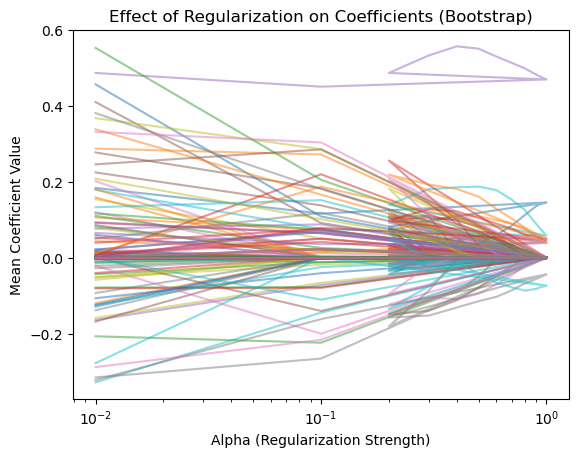

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.utils import resample

# Define a function for bootstrapping and estimating coefficients
def bootstrap_lasso(gene_expression, drug_response, alpha, num_iterations=100):
    coef_results = []

    for _ in range(num_iterations):
        X_bootstrap, y_bootstrap = resample(gene_expression, drug_response, random_state=42)
        lasso = Lasso(max_iter=20000, alpha=alpha)
        lasso.fit(X_bootstrap, y_bootstrap)
        selected_features_coef = lasso.coef_
        coef_results.append(selected_features_coef)

    return np.array(coef_results)

# Define the hyperparameters to search
alphas = [0.01, 0.1, 1.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Perform 100 iterations of Lasso regression with bootstrap for each alpha
mean_coefs = []

for alpha in alphas:
    coef_results = bootstrap_lasso(gene_expression, drug_response, alpha)
    mean_coefs.append(np.mean(coef_results, axis=0))

# Convert mean_coefs to a numpy array for easier manipulation
mean_coefs = np.array(mean_coefs)

# Visualize the profile of the Lasso regression coefficients
plt.plot(alphas, mean_coefs, alpha=0.5)
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Coefficient Value')
plt.title('Effect of Regularization on Coefficients (Bootstrap)')
plt.show()


As to what concerns the Bias, when we have a high value for the alpha there is a strong regularization which penalizes the model for using too many features. This leads to higher bias, as the model is forced to be simpler and may not capture the complexity in the data.

When the alpha decreases, the regularization effect weakens. The model is less constrained and has the flexibility to capture more complex relationships in the data. This can reduce bias, allowing the model to fit the training data more closely.

With strong regularization, the model is less likey to overfit to the training data therefore reducing the variance as the predictions in the model are less influenced by noise in the training data.

As the value for alpha decreases, the model becomes more flexible and can capture intricate details in the training data. This can lead to higher variance as the model may start to overfit to the noise in the data. This results in a model that performs well on the training data but poorly on unseen data.

### Logistic regression

$$
\text{minimize}_{\beta} \left\{ -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\sigma(\mathbf{x}_i^T \mathbf{\beta})) + (1 - y_i) \log(1 - \sigma(\mathbf{x}_i^T \mathbf{\beta})) \right] + \lambda_1 \|\mathbf{\beta}\|_1 + \lambda_2 \|\mathbf{\beta}\|_2^2 \right\}
$$
